In [5]:
# importing packages
import numpy as np
import h5py
from networkx.algorithms.bipartite.basic import color
from tifffile import xml2dict

from src import io, corr
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import os, glob

In [6]:
# exp_id = '251014_1701'
# server_windows = 'Z:/princess/data'
# /home/ptarabishi/repos/ROI_analysis/251014_1701

# supervox_path = fr"Z:/princess/data/251014_1701/processed/251014_1701_supervoxels.h5"
# labels_path = fr"Z:/princess/data/251014_1701/processed/251014_1701_labels.h5"

In [7]:
exp_date = '251014'
exp_num = '1701'

experiment_path = io.get_experiment(exp_date, exp_num)
print(experiment_path)
supervox_path = io.get_file(experiment_path, 'processed', '*supervoxels.h5')
labels_path = io.get_file(experiment_path, 'processed', '*labels.h5')
print(supervox_path, labels_path)

# open h5 and pull data
with h5py.File(labels_path, 'r') as labels_hf:
    cluster_labels = labels_hf['labels'][...]

with h5py.File(supervox_path,'r') as supervox_hf:
    ca_signal = supervox_hf['ca_signal'][...]
    fictrac_sp = supervox_hf['smoothed_speed'][...]
    fictrac_t = supervox_hf['fictrac_time'][...]
    camera_fr = supervox_hf['camera_fr'][...]
    scope_fr = supervox_hf['scope_fr'][...]
    brain_dim = supervox_hf['brain_dimensions'][...]

# maui time conversions
frames = [x for x in range(1, ca_signal.shape[-1])]
volume_per_s = scope_fr/ca_signal.shape[0] # volume rate in Hz
maui_time = [0] + [x / volume_per_s for x in frames]

# fictrac time conversions
fic_time = fictrac_t / camera_fr

/home/ptarabishi/repos/ROI_analysis/251014_1701
/home/ptarabishi/repos/ROI_analysis/251014_1701/processed/251014_1701_supervoxels.h5 /home/ptarabishi/repos/ROI_analysis/251014_1701/processed/251014_1701_labels.h5


In [8]:
# to run pearson correlations, first downsize the fictrac data to match the calcium data size

def downsize_dataset(fast_ds, slow_ds, slice_num=0):
    slow_signal = pd.DataFrame(slow_ds[slice_num, :, :].T)
    slow = slow_signal.to_numpy()
    fast = fast_ds

    max_divider = fast.shape[0] // slow.shape[0]
    fast_cut = fast[:slow.shape[0]*max_divider] # cut excess behavior data
    fast_reshaped = np.reshape(fast_cut, (slow.shape[0], -1))
    fast_downsample = np.mean(fast_reshaped, axis=1)
    print(fast_downsample.shape[0], slow.shape[0])

    return fast_downsample

def pearson_analysis(cluster_labels, resampled_behavior):
    pearson_arr = []
    for slice_idx, clusters, in enumerate(cluster_labels):
        for cluster_idx, signal in enumerate(clusters):
            corr = pearsonr(signal, resampled_behavior).statistic
            pearson_arr.append(corr)
    # pearson_arr_reshape = np.reshape(pearson_arr, (cluster_labels.shape[0], -1))

    return pearson_arr

def sort_descending(array):
    sort_ascending = np.argsort(array)
    flipped = np.flip(sort_ascending)
    return flipped

In [9]:
print(ca_signal.shape)

(31, 500, 978)


In [10]:
fictrac_resample = corr.downsize_dataset(fictrac_sp, ca_signal)

pearson_arr = corr.pearson_analysis(ca_signal, fictrac_resample)
sorted_pearson = corr.sort_descending(pearson_arr)
print(len(pearson_arr)) # [slices, pearson coefficient of each roi]

978 978
15500


In [11]:
signal_reshape = np.reshape(ca_signal, (ca_signal.shape[0]*ca_signal.shape[1], -1))
print(signal_reshape.shape)

(15500, 978)


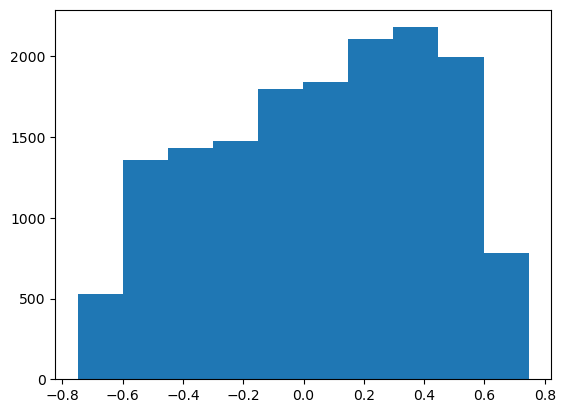

In [12]:
plt.hist(pearson_arr)
plt.show()

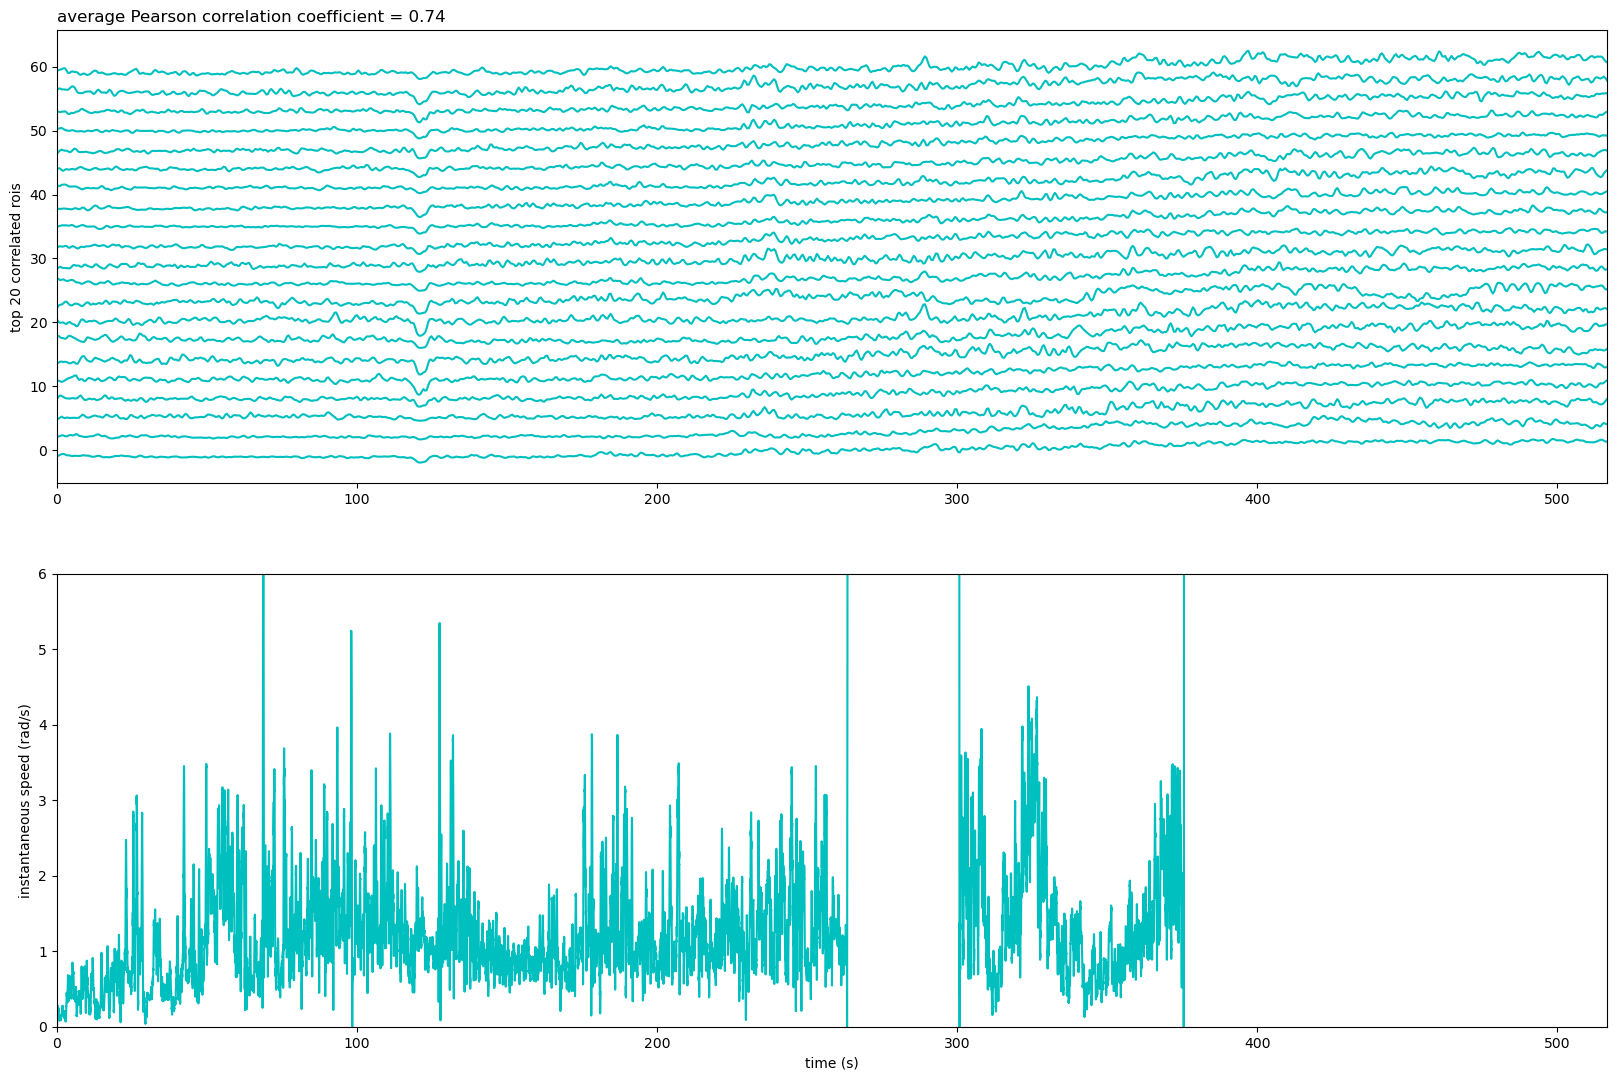

In [30]:
mean_corr = []
y_shift = 3
roi_n = 20

plt.figure(figsize=(20,20))
plt.subplot( 3, 1, 1)
for idx, cluster_idx in enumerate(sorted_pearson):
    trace = signal_reshape[cluster_idx, :] + (y_shift*idx)
    plt.plot(maui_time, trace, color='c')
    mean_corr.append(pearson_arr[cluster_idx])
    if idx == roi_n:
        break
plt.title(fr'average Pearson correlation coefficient = {np.mean(mean_corr):.2f}', loc = 'left')
plt.xlim(xmin=0, xmax=max(maui_time))
plt.ylabel('top 20 correlated rois')

plt.subplot(312)
plt.plot(fic_time, fictrac_sp, color='c')
plt.ylim(0,6)
plt.xlim(xmin=0, xmax=max(maui_time))
plt.xlabel('time (s)')
plt.ylabel('instantaneous speed (rad/s)')
plt.show()

In [14]:
cluster_labels.shape
brain_dim = brain_dim.reshape(-1)
brain_dim

array([256, 256,  31, 978])

In [15]:
print(cluster_labels.shape, len(pearson_arr))

(31, 65536) 15500


In [23]:
import seaborn as sns
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

(15500, 978)


<Axes: >

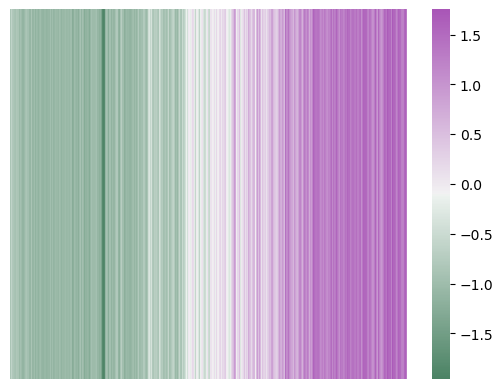

In [56]:
all_traces = ca_signal.reshape(-1, ca_signal.shape[-1])
print(all_traces.shape)
sns.heatmap(all_traces[3073, np.newaxis], cmap=cmap, xticklabels=False, yticklabels=False)

In [ ]:
print(sorted_pearson)
# print(all_traces[0], all_traces.shape[1])
# print(reordered[0])

[3073  446 3787 ...   98  892 1773]
[-9.68421123e-01 -8.63090141e-01 -7.26323751e-01 -6.33182537e-01
 -6.04495891e-01 -6.75812296e-01 -8.08027804e-01 -8.28509901e-01
 -8.35764806e-01 -9.21933451e-01 -9.30637708e-01 -8.87547737e-01
 -9.01452790e-01 -9.17507347e-01 -9.12507897e-01 -8.95259345e-01
 -8.17143380e-01 -8.07655377e-01 -8.63083668e-01 -8.57109949e-01
 -8.74306229e-01 -9.61442831e-01 -1.03881160e+00 -1.05043863e+00
 -1.00370425e+00 -9.33973333e-01 -8.95696525e-01 -9.09300595e-01
 -1.01658201e+00 -1.12924313e+00 -1.11683268e+00 -1.08291466e+00
 -1.12165215e+00 -1.12882595e+00 -1.08571515e+00 -1.03566276e+00
 -9.69679127e-01 -9.10379563e-01 -9.25372410e-01 -9.33290908e-01
 -8.58680619e-01 -8.51178695e-01 -9.14070205e-01 -9.39985343e-01
 -9.43665286e-01 -9.48997945e-01 -9.83291497e-01 -1.03838993e+00
 -1.09732858e+00 -1.14175863e+00 -1.09673413e+00 -9.77075406e-01
 -8.72462987e-01 -8.68872369e-01 -9.87417932e-01 -1.10712813e+00
 -1.12397955e+00 -1.09166158e+00 -1.03997522e+00 -9.83

(15500, 978)


<Axes: >

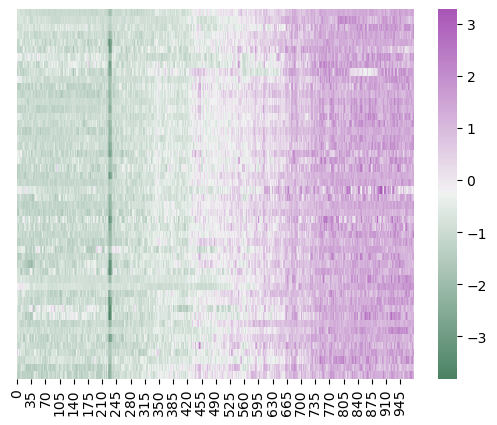

In [58]:
reordered = all_traces[sorted_pearson]
print(reordered.shape)
# for idx, i in enumerate(sorted_pearson):
#     if idx <1:
#         reordered = print(all_traces[i])
sns.heatmap(reordered[0:50], cmap=cmap, yticklabels=False)